In [1]:
import json
import numpy as np
import pandas as pd
import os
import h5py
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X = []
y = []
with h5py.File("datasets/behaviours.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
# the robot_behaviors.hdf5 differs from behaviors.hdf5 in that it also includes the motor position encodings        

        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)


#0         "/roboy/middleware/MotorStatus/displacement/3",
#1         "/roboy/middleware/MotorStatus/displacement/5",
#2         "/roboy/middleware/MotorStatus/displacement/6",
#3         "/roboy/middleware/MotorStatus/displacement/10",
#4         "/roboy/middleware/MotorStatus/displacement/12",
#5         "/roboy/middleware/MotorStatus/displacement/13",
#6         "/roboy/middleware/MotorStatus/position/3",
#7         "/roboy/middleware/MotorStatus/position/5",
#8         "/roboy/middleware/MotorStatus/position/6",
#9         "/roboy/middleware/MotorStatus/position/10",
#10         "/roboy/middleware/MotorStatus/position/12",
#11        "/roboy/middleware/MotorStatus/position/13",
#12         '/mocap/MarkerPose/position/x',
#13         '/mocap/MarkerPose/position/y',
#14         '/mocap/MarkerPose/position/z',

Loading frontal_swings_upwards
Loading lateral_rotations_clockwise
Loading marker_up
Loading marker_up_frontal_swing
Loading marker_up_lateral_rotations
Loading marker_up_lateral_swing
Loading motor_marker_1
Loading random_motions
(92514, 15) (92514,)


In [3]:
# Pose information (= motor camera image, (x,y,z) + quaternion)
X_pose = X[:,12:15]   # only the first two components (x, y) have non-zero values
# Motor displacements
X_disp = X[:,0:5]   # last motor component is zero
#X_disp[X_disp < 0] = 0

#Angular position
X_ang = X[:,6:11]   # last motor component is zero
#X_ang[X_ang < 0] = 0


print(X_pose.shape)
print(X_disp.shape)
print(X_ang.shape)

(92514, 3)
(92514, 5)
(92514, 5)


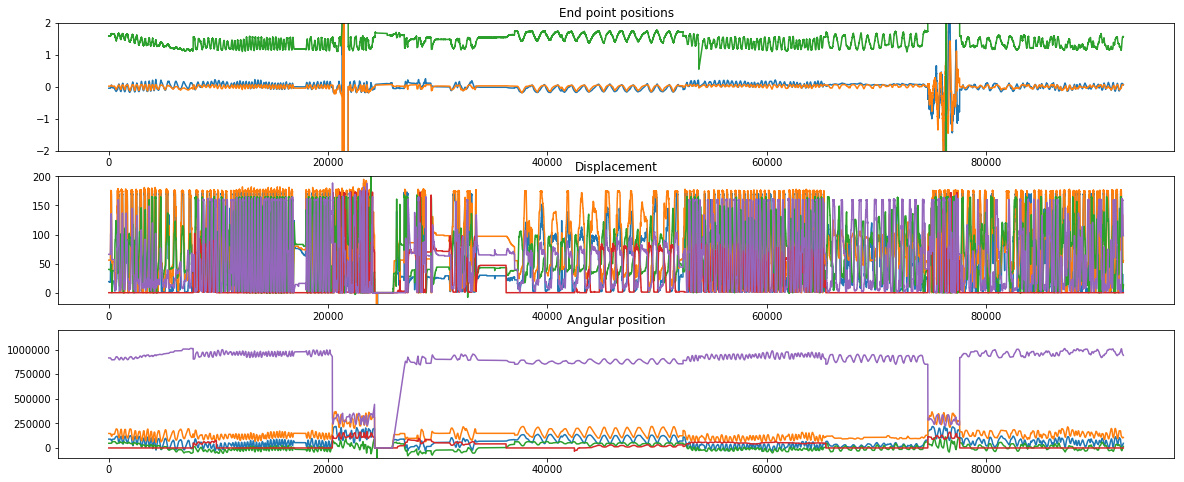

In [4]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data')

In [5]:
# removing outliers
for i in range(3):
    X_pose = X_pose[X_pose[:,i] < 2,:]
    X_pose= X_pose[X_pose[:,i] > -2,:]

for i in range(5):
    X_disp = X_disp[X_disp[:,i] < 200,:]
    X_disp= X_disp[X_disp[:,i] > -20,:]
    
for i in range(5):
    X_ang = X_ang[X_ang[:,i] < 1200000,:]
    X_ang= X_ang[X_ang[:,i] > -10000,:]

    
# conversion to tensors    
x = np.array(X_ang)
y = np.array(X_pose)
x  = torch.from_numpy(x)
y = torch.from_numpy(y)

# We need to normalise the data by the max value. This is necessary because otherwise the gradient for sigmoid will become zero for higher values
(a,b)= torch.max(x,0)
(norm,d)= torch.max(a,0)
x = x/norm

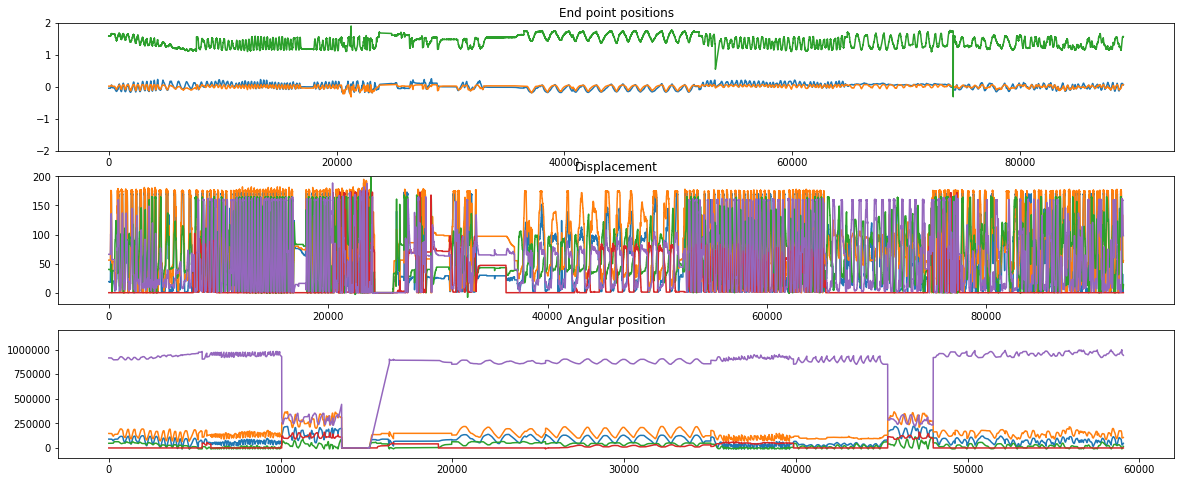

In [6]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data_clean')

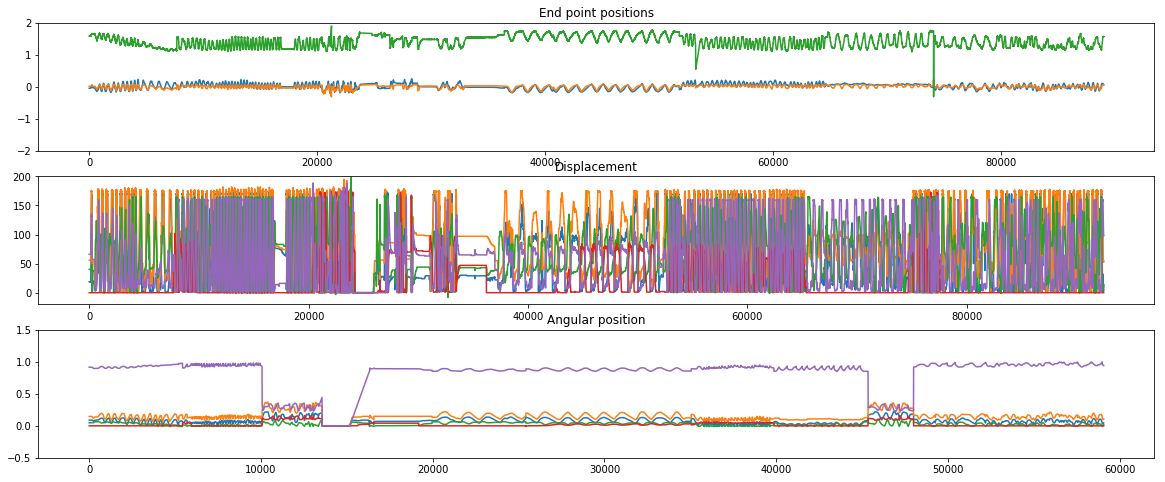

In [7]:
# plotting after removing outliers

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(x.numpy())
ax3.set_ylim([-0.5,1.5])
ax3.set_title("Angular position")
plt.show()
fig.savefig('try')

In [8]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 500     # Random noise dimension coming into generator, per output vector
g_hidden_size = 1000   # Generator complexity
g_output_size = 500    # size of generated output vector
d_input_size = 500   # Minibatch size - cardinality of distributions
d_hidden_size = 1000   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = 128

d_learning_rate = 2e-5  # 2e-4
g_learning_rate = 2e-5
optim_betas = (0.9, 0.999)
num_epochs = 100000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

# ### Uncomment only one of these
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))
    
    
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)    
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)   #

# .t() returns the same variable but with transposed data

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
#criterion = nn.MSELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

mus_d = torch.zeros(num_epochs,5)
stds_d = torch.zeros(num_epochs,5)
mus_g = torch.zeros(num_epochs,5)
stds_g = torch.zeros(num_epochs,5)

d_real_error_list = torch.zeros(num_epochs)
d_fake_error_list = torch.zeros(num_epochs)
g_error_list = torch.zeros(num_epochs)




Using data [Raw data]


In [9]:
# trainning of the model

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        #d_real_data = Variable(d_sampler(d_input_size)) # 100 points Variable
        #start  = random.sample(range(0, len(X_ang)-101), 1)[0]
        #end = start + 100        
        #d_real_data = x[start:end,:]
        
        start  = random.sample(range(0, len(X_ang)-101),minibatch_size)
        end = torch.ones(minibatch_size).type(torch.IntTensor) 
        d_real_data = Variable(torch.ones(minibatch_size,100,5))
        for i in range(minibatch_size):
            end[i] =  start[i] + 100
            d_real_data.data[i,:,:] = x[start[i]:end[i],:]
        
        data_mean_d = torch.mean(d_real_data.data,0)
        mus_d[epoch,:] = torch.mean(data_mean_d,0)
        stds_d[epoch,:] = torch.std(data_mean_d,0)
        
        d_real_data =  Variable(d_real_data.data.resize_((minibatch_size,500))) #10x500 points
        d_real_data  = d_real_data.type(torch.FloatTensor)
        d_real_decision = D(preprocess(d_real_data))  # 1 point Variable
        d_real_error = criterion(d_real_decision, Variable(torch.ones(minibatch_size)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        d_real_error_list[epoch] = extract(d_real_error)[0]
        
        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)) #100 points variable
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels. #100x5 points
        #d_fake_data.data =  d_fake_data.data.resize_((1,500)) #500 points
        d_fake_decision = D(preprocess(d_fake_data))   # 1 point
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(minibatch_size)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()   
        
        d_fake_error_list[epoch] = extract(d_fake_error)[0]
        
    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))  #10x500 points
        g_fake_data = G(gen_input)   # 10 x 500 points
        
        #g_fake_data.data = g_fake_data.data.resize_((1,500))
        g_fake_data  = g_fake_data.type(torch.FloatTensor)
        
        dg_fake_decision = D(preprocess(g_fake_data))  # 1 point
        g_error = criterion(dg_fake_decision, Variable(torch.ones(minibatch_size)))  # we want to fool, so pretend it's all genuine
        
        #print(g_error)
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
        g_error_list[epoch] = extract(g_error)[0]
        
        data_mean_g = torch.mean(g_fake_data.data.resize_((minibatch_size,100,5)),0)
        mus_g[epoch,:] = torch.mean(data_mean_g,0)
        stds_g[epoch,:] = torch.std(data_mean_g,0)
    
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error),
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



/home/pranshulsaini/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.7035977244377136/0.6800594329833984 G: [0.7248387932777405] (Real: [0.22177019647005902, 0.32578354733070469], Fake: [-0.0002652093987308035, 0.28577986960264151]) 
200: D: 0.5811143517494202/0.6842949986457825 G: [0.8668978810310364] (Real: [0.21748382726034657, 0.32459318530475506], Fake: [0.18126868688864489, 0.72389662435119295]) 
400: D: 0.40610095858573914/0.789838969707489 G: [0.8705769181251526] (Real: [0.219828034321355, 0.32135139666205453], Fake: [0.12780262588779442, 0.86803981543540232]) 
600: D: 0.39220815896987915/0.5150614380836487 G: [1.1592824459075928] (Real: [0.22051576060330177, 0.32472065624040269], Fake: [0.27463959323659221, 0.92153540907496123]) 
800: D: 0.640421986579895/0.7425861954689026 G: [0.6876230239868164] (Real: [0.22013037216823042, 0.32924557986697378], Fake: [0.22367409373115787, 0.41171830017980648]) 
1000: D: 0.6979424953460693/0.7669724822044373 G: [0.659896194934845] (Real: [0.21648975493545905, 0.3257630999648255], Fake: [0.200347660102

KeyboardInterrupt: 

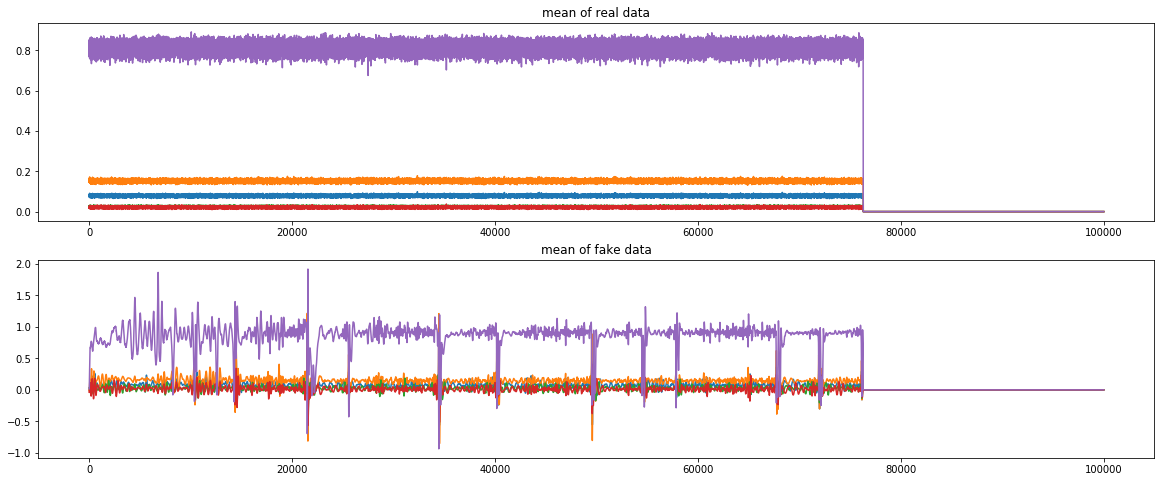

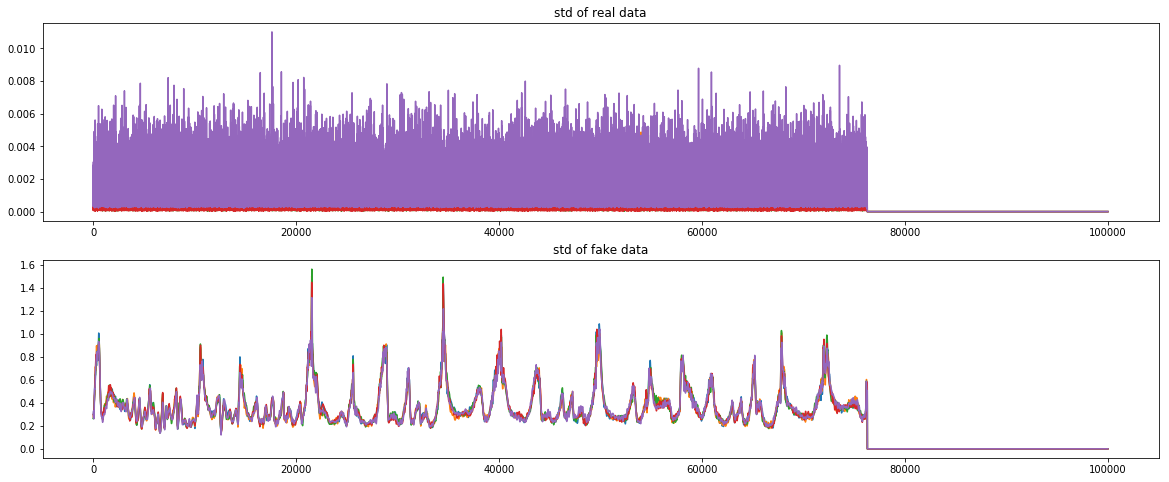

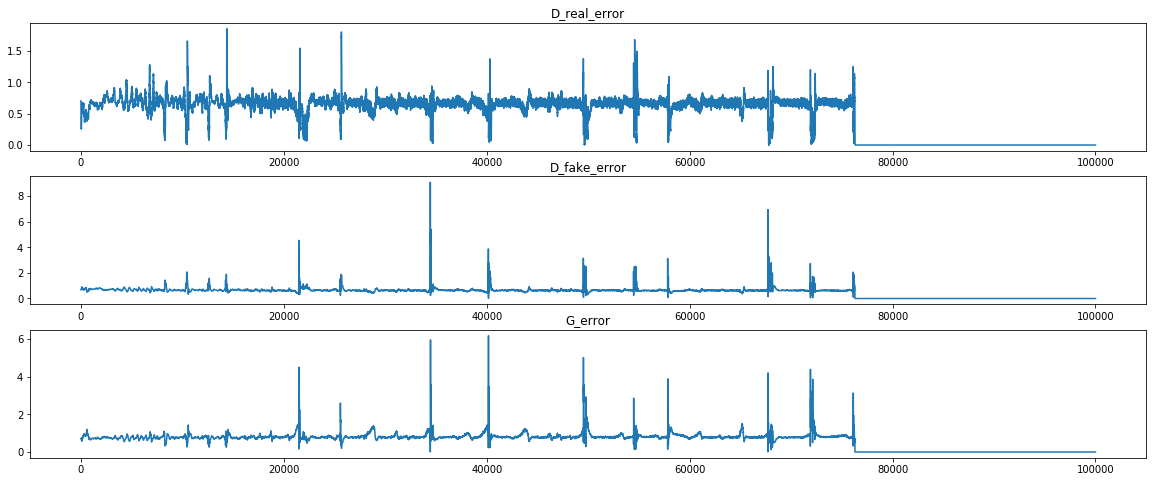

In [10]:
#plotting the statistic of generator function

fig1 = plt.figure(figsize=(20,8))

ax1 = fig1.add_subplot(2,1,1)
ax1.plot(mus_d.numpy())
#ax1.set_ylim([-2,2])
ax1.set_title("mean of real data")

ax2= fig1.add_subplot(2,1,2)
ax2.plot(mus_g.numpy())
#ax1.set_ylim([-2,2])
ax2.set_title("mean of fake data")
fig1.savefig('Mean_comparison')

fig2 = plt.figure(figsize=(20,8))
ax3 = fig2.add_subplot(2,1,1)
ax3.plot(stds_d.numpy())
#ax2.set_ylim([-20,200])
ax3.set_title("std of real data")

ax4 = fig2.add_subplot(2,1,2)
ax4.plot(stds_g.numpy())
#ax2.set_ylim([-20,200])
ax4.set_title("std of fake data")
fig2.savefig('std_comparison')


# plotting the errors

fig3 = plt.figure(figsize=(20,8))
ax5 = fig3.add_subplot(3,1,1)
ax5.plot(d_real_error_list.numpy())
#ax2.set_ylim([-20,200])
ax5.set_title("D_real_error")

ax6 = fig3.add_subplot(3,1,2)
ax6.plot(d_fake_error_list.numpy())
#ax2.set_ylim([-20,200])
ax6.set_title("D_fake_error")

ax7 = fig3.add_subplot(3,1,3)
ax7.plot(g_error_list.numpy())
#ax2.set_ylim([-20,200])
ax7.set_title("G_error")

fig3.savefig('loss_comparison')

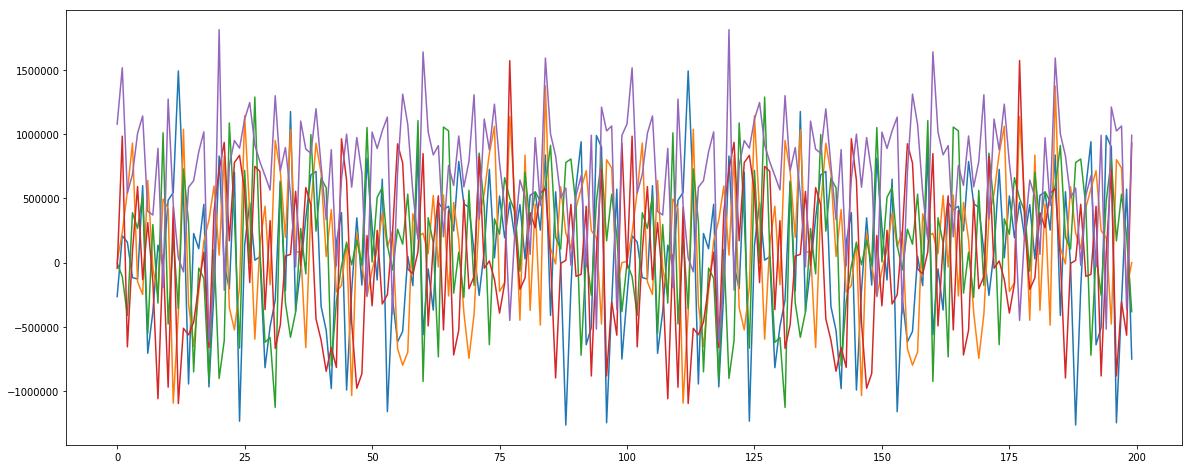

In [12]:
n = X_ang.shape[0]

m = g_input_size//5

turns = n//m

for i in range(2):
    inp = Variable(gi_sampler(minibatch_size, g_input_size))
    result = G(inp)
    data = torch.mean(result.data,0)
    data = data.resize_((100,5))
    data = data.numpy()
    if i>0:
        data = np.concatenate((total_data, data), axis=0)
        
    total_data = data

total_data = total_data *norm.numpy() 

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(total_data)
plt.show()
ax1.set_title("Angular_displacement")
fig.savefig('generated_disp_data')


In [108]:
print(total_data)


[[
-3667.3254
[torch.DoubleTensor of size 1]
  
-10648.0275
[torch.DoubleTensor of size 1]
  
-4441.3481
[torch.DoubleTensor of size 1]
  
-7947.6987
[torch.DoubleTensor of size 1]
  
1.00000e+05 *
  1.1041
[torch.DoubleTensor of size 1]
]
 [
-10102.1426
[torch.DoubleTensor of size 1]
  
-32404.0983
[torch.DoubleTensor of size 1]
  
-16000.9761
[torch.DoubleTensor of size 1]
  
 2142.2635
[torch.DoubleTensor of size 1]
  
-3912.9879
[torch.DoubleTensor of size 1]
]
 [
-42058.1620
[torch.DoubleTensor of size 1]
  
 27587.0579
[torch.DoubleTensor of size 1]
  
-10602.5337
[torch.DoubleTensor of size 1]
  
-3251.8765
[torch.DoubleTensor of size 1]
  
-22992.3030
[torch.DoubleTensor of size 1]
]
 [
 60685.4074
[torch.DoubleTensor of size 1]
  
 16029.5074
[torch.DoubleTensor of size 1]
  
-17273.4007
[torch.DoubleTensor of size 1]
  
-4248.3495
[torch.DoubleTensor of size 1]
  
-5815.2108
[torch.DoubleTensor of size 1]
]
 [
-14642.6229
[torch.DoubleTensor of size 1]
  
-13151.4588
[torch.D

In [95]:
a= torch.rand(5,2)
b = a.resize_((1,10))
c = Variable(b)
print(b)

[[ 0.35304725  0.36623389  1.52204013  1.20104718  0.33690444  1.93653858
   1.06906962  0.83719468  0.22029921  0.77823061]]


In [8]:
def get_distribution_sampler(mu, sigma):
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [30]:
gen = get_distribution_sampler(0,1)
values = gen(5,3)
print(values)
(a,b)= torch.max(values,0)
(c,d)= torch.max(a,0)
print(c)
#print(torch.mean(values,1))


-0.6446  0.2226  2.7998
-0.2924  0.8934  0.0682
 1.1541  0.6699 -0.7529
 1.5357 -0.5266  0.3637
 0.1553 -1.1598  0.7995
[torch.FloatTensor of size 5x3]


 2.7998
[torch.FloatTensor of size 1]



In [43]:
import random
start  = random.sample(range(0, len(X_ang)-101), 10)
end = torch.ones(10).type(torch.IntTensor) 
data = torch.ones(10,100,5)
for i in range(10):
    end[i] =  start[i] + 100
    data[i,:,:] = x[start[i]:end[i],:]

m = torch.mean(data,0)
n = torch.mean(m,0)
print(n)
print(data)


 0.2714
 0.3544
 0.3372
 0.0162
 0.1163
[torch.FloatTensor of size 5]


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0706
  0.0000  0.0000  0.0000  0.0000  0.0706
  0.0000  0.0000  0.0000  0.0000  0.0706
                   ⋮                    
  0.0101  0.1008  0.1916  0.0000  0.0958
  0.0050  0.0907  0.1916  0.0000  0.0958
  0.0050  0.0807  0.1916  0.0000  0.0958

( 1 ,.,.) = 
  0.1260  0.2621  0.1664  0.0000  0.0000
  0.1311  0.2621  0.1664  0.0000  0.0000
  0.1311  0.2672  0.1664  0.0000  0.0000
                   ⋮                    
  0.1361  0.2773  0.1714  0.0000  0.0000
  0.1361  0.2773  0.1714  0.0000  0.0000
  0.1361  0.2773  0.1714  0.0000  0.0000

( 2 ,.,.) = 
  0.8620  0.4184  0.8217  0.0000  0.0050
  0.8517  0.4386  0.8267  0.0000  0.0050
  0.8517  0.4537  0.8217  0.0000  0.0050
                   ⋮                    
  0.8368  0.8768  0.6755  0.0000  0.0907
  0.8418  0.8721  0.6755  0.0000  0.0907
  0.8469  0.8721  0.6805  0.0000  0.0907
... 

( 7 ,.,.) = 
  0.00

In [55]:
aa = torch.ones((2,3))
print(aa)
bb = torch.zeros((4,3))
print(bb)
cc = np.append(aa.numpy(), bb.numpy(), axis=0)
print(cc)
dd= []
dd = np.append(dd,cc,axis=0)



 1  1  1
 1  1  1
[torch.FloatTensor of size 2x3]


 0  0  0
 0  0  0
 0  0  0
 0  0  0
[torch.FloatTensor of size 4x3]

[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


ValueError: all the input arrays must have same number of dimensions